In [11]:
# ask chatgpt to parse

# query sentence
query_dict = {
        'Specific Category': "Pants",
        'Color': "White",
        'Material': "light weight",
        'Features': "pockets and nice buttons",
        'Style': "tailored fitted",
        'Occasion': "work"
    }

score_weights = {
    'Specific Category': -1,
    'Color': 0.7,
    'Material': 0.5,
    'Features': 0.6,
    'Style': 0.3,
    'Occasion': 0.4
}


# import libraries

In [1]:
import torch
import os
import json
import re
import pandas as pd
from dotenv import load_dotenv
from openai import OpenAI
from PIL import Image
import matplotlib.pyplot as plt

# access to API key

In [2]:
## access to API key
notebook_directory = "C:/Users/Esra/Desktop/Deep_Learning/Image_Classification/Fashion/Classify_ThreadUp_Images"

# Construct the absolute path to the api.env file
env_file_path = os.path.join(notebook_directory, "api.env")

# Load environment variables from the api.env file
load_dotenv(env_file_path, override=True)

# Access the API key
api_key = os.getenv("OPENAI_API_KEY")

os.environ['OPENAI_API_KEY'] = api_key

# create database

In [4]:
# Load the CSV file into a DataFrame
captions_path = "C:/Users/Esra/Desktop/Deep_Learning/Image_Classification/Fashion/Classify_ThreadUp_Images/data/dedupped_descriptions3.csv"
captions = pd.read_csv(captions_path)

# Define a function to parse the descriptions
def parse_description(description):
    # Create a dictionary to hold the parsed data
    parsed_data = {
        'Specific Category': None,
        'Color': None,
        'Material': None,
        'Features': None,
        'Style': None,
        'Occasion': None
    }
    # Split the description into lines
    lines = description.split('\n')
    # Process each line
    for line in lines:
        # Use regex to capture the field name and value
        match = re.match(r'- (.*?): (.*)', line)
        if match:
            field_name = match.group(1).strip()
            field_value = match.group(2).strip()
            # Map the field name to the corresponding dictionary key
            if field_name in parsed_data and field_name:
                parsed_data[field_name] = field_value
    return pd.Series(parsed_data)

# Apply the function to each description and join the result to the original DataFrame
parsed_descriptions = captions['description'].apply(parse_description)
captions = captions.join(parsed_descriptions)

#drop descriptions column
# captions.drop('description', axis=1, inplace=True)

# drop the images with none values
captions = captions.dropna().reset_index(drop=True)
captions

,filename,description,Specific Category,Color,Material,Features,Style,Occasion
0,item100001657.jpg,- Specific Category: Trousers\n- Color: Solid ...,Trousers,"Solid coral red with a slightly glossy finish,...","Appears to be a synthetic blend, possibly with...","Front button closure with zipper fly, possibly...","Straight-leg fit with a relaxed cut, likely in...",Suitable for business casual events or elevate...
1,item100246366.jpg,- Specific Category: Blouse\n- Color: White wi...,Blouse,"White with a soft matte finish, no visible pat...","Appears to be a lightweight, woven fabric, pos...","Button-up front closure with white buttons, lo...",Fashion-forward feminine style with a structur...,Suitable for business
2,item103003446.jpg,- Specific Category: Blouse\n- Color: Deep plu...,Blouse,Deep plum with a solid pattern and a somewhat ...,"Appears to be a lightweight fabric, potentiall...","Long sleeves with slits and button cuffs, V-ne...","Relaxed fit with a flowing silhouette, potenti...","Suitable for business casual environments, sem..."
3,item103756367.jpg,- Specific Category: Blouse\n- Color: Deep bur...,Blouse,Deep burgundy with a slightly crinkled texture...,"Looks like a synthetic blend, possibly with vi...","Long sleeves, V-neckline without closures, no ...","Relaxed fit with a flowing silhouette, likely ...","Suitable for smart-casual occasions, office we..."
4,item104132211.jpg,- Specific Category: Blouse\n- Color: Off-whit...,Blouse,"Off-white or ivory, with no visible patterns a...","Appears to be a lightweight, possibly syntheti...","Classic shirt collar, front button closure, bu...","Tailored fit with long sleeves, intended to be...",Suitable for professional settings
5,item105067431.jpg,- Specific Category: Trousers\n- Color: Deep r...,Trousers,"Deep red with a slight sheen, uniform throughout","Appears to be a synthetic blend, possibly poly...","Flat front, no visible pockets or closures, an...","Straight leg cut with a slightly relaxed fit, ...",Suitable for business casual settings or smart...
6,item106068596.jpg,- Specific Category: Dress Shirt\n- Color: Whi...,Dress Shirt,"White with a semi-gloss finish, no patterns","Appears to be a smooth, lightweight cotton or ...","Button-up front, a standard pointed collar, lo...","Traditional, with a regular fit and a straight...",Suitable for formal events
7,item106129754.jpg,- Specific Category: Long-sleeve blouse\n- Col...,Long-sleeve blouse,"Deep purple with a slight sheen, uniform throu...","Appears to be a lightweight knit fabric, possi...","Round neckline, asymmetrical hemline that is l...","Loose, relaxed fit with a flowing drape, exten...",Suitable for casual to smart


## create embeddings

In [5]:
client = OpenAI()

def get_embedding(text, model="text-embedding-3-small"):
   text = text.replace("\n", " ")
   return client.embeddings.create(input = [text], model=model).data[0].embedding

In [ ]:

# Initialize a dictionary to store embeddings for each column
embeddings_dict = {
    'Specific Category': [],
    'Color': [],
    'Material': [],
    'Features': [],
    'Style': [],
    'Occasion': []
}

# Loop through each column and get embeddings for each entry
for column in embeddings_dict.keys():
    for text in captions[column]:
            embeddings_dict[column].append(get_embedding(text, model='text-embedding-3-small'))


In [17]:
# Specify the filename
filename = 'embeddings_dict.json'

with open(filename, 'w') as f:
    json.dump(embeddings_dict, f, indent=4)
    
#maybe in future, when you have a bigger database, json might be slower

# try embedding batch for fun

In [52]:
# response = client.embeddings.create(
#   model="text-embedding-ada-002",
#   input=["First piece of text", "Second piece of text", "Third piece of text"]
# )

# embed_list = [response.data[i].embedding for i in range(len(response.data))]
# len(embed_list[1])

# response = client.embeddings.create(input = ["First piece of text"], model="text-embedding-ada-002").data

# res_list = [response[i].embedding for i in range(len(response))]
# len(res_list[0])

1536

In [47]:
# len(response.data[0].embedding)

1536

In [24]:
# def get_embedding_batch(text_list, model="text-embedding-3-small"):
#         return client.embeddings.create(input = text_list, model=model).data[0].embedding

In [25]:
# for subembed_key in embeddings_dict.keys():
#         text_list = []
#         for text in captions[subembed_key]:
#             text_list.append(text.replace("\n", " "))
            
#         embeddings_dict[subembed_key].append(get_embedding_batch(text_list, model='text-embedding-3-small'))

In [27]:
# # Specify the filename
# filename = 'embeddings_batch_dict.json'

# with open(filename, 'w') as f:
#     json.dump(embeddings_dict, f, indent=4)
    
# #maybe in future, when you have a bigger database, json might be slower

# query embeddings

In [18]:
# query embeddings
# NOTE to ESRA: you could put the code like below inside of a function! (everything is inside of functions)

# Initialize a dictionary to store embeddings for each column
query_emb_dict = {
    'Specific Category': [],
    'Color': [],
    'Material': [],
    'Features': [],
    'Style': [],
    'Occasion': []
}

# Loop through each column and get embeddings for each entry
for column in query_dict:
    text = query_dict[column]
    if text:
        query_emb_dict[column].append(get_embedding(text, model='text-embedding-3-small'))

# calculate similarity score

In [19]:

# search for the best match between query and database embeddings

def norm_embeddings(embeds):
    norms = torch.norm(embeds, dim=1, keepdim=True)
    normalized_embeddings = embeds / norms
    return normalized_embeddings

def torchify_norm(emb_dict):
    new_dict = {}
    for col, val in emb_dict.items():
        torch_val = torch.tensor(val)
        if val:
            new_dict[col] = norm_embeddings(torch_val)
    return new_dict

query_emb_dict_torch = torchify_norm(query_emb_dict)
embeddings_dict_torch = torchify_norm(embeddings_dict)


def search_match(query_emb_dict_torch, embeddings_dict_torch, score_weights):
    N = embeddings_dict_torch["Color"].shape[0]
    weighted_sim = torch.zeros((1, N))
    for col, val in query_emb_dict_torch.items(): 
        cosine_sim_matrix = torch.mm(val, embeddings_dict_torch[col].t()) # or use @
        weighted_sim +=  cosine_sim_matrix * score_weights[col]      
    return weighted_sim

scores = search_match(query_emb_dict_torch, embeddings_dict_torch, score_weights)
# show the best matching 3 images

# visualize top 3 best matching images

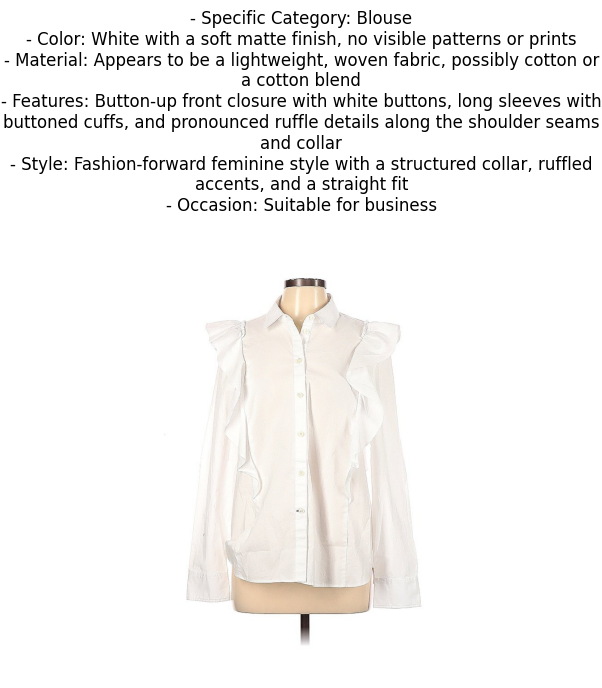

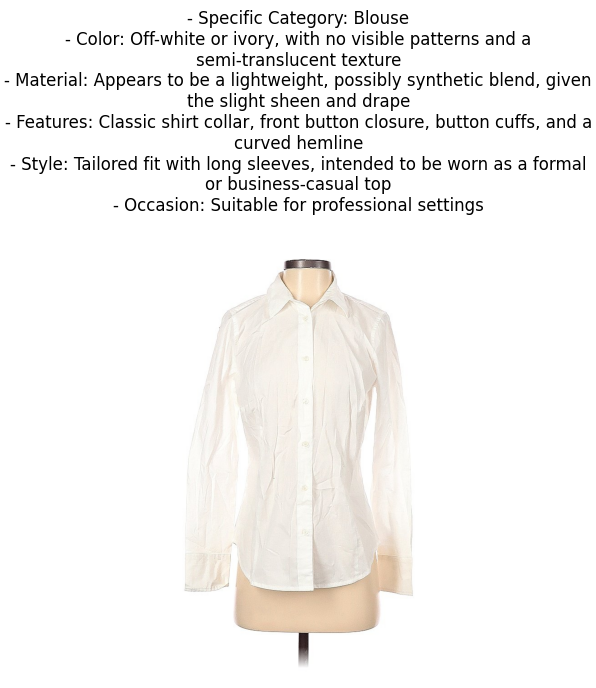

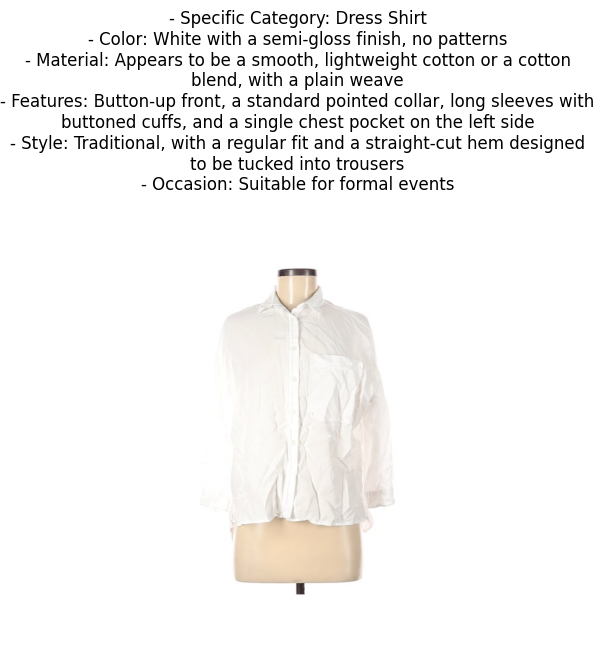

: 

In [20]:
output_dir = "C:/Users/Esra/Desktop/Deep_Learning/Image_Classification/Fashion/Classify_ThreadUp_Images/data/StanfordJpegs/dedupped_images/"

top_ix = scores.topk(3).indices.tolist()[0]
# Iterate over the responses and display each image with its description
for item in top_ix:
    
    img_path = os.path.join(output_dir, captions["filename"][item])
    
    # Open the image
    img = Image.open(img_path)

    # Set up the matplotlib figure
    plt.figure(figsize=(6, 6))

    # Display the image
    plt.imshow(img)
    plt.axis('off')  # Remove axis ticks

    # Display the description
    plt.title(captions["description"][item], wrap=True)

    # Show the plot
    plt.show()